## Need to geerate performance metrics for the following models

|         | tr_phase1, pf_phase1 | tr_phase1, pf_expiry | tr_expiry, pf_expiry |   |
|---------|----------------------|----------------------|----------------------|---|
| seg_glm |                      |                      |                      |   |
| rf_500  | ranger_03_           |                      |                      |   |
|         |                      |                      |                      |   |

### Metrics include: Gains Curves; Lift values; for each tld-registrar-reg_arpt: sum(prob) vs count (renewed)


# Housekeeping

In [13]:
# install.packages("ROCR")

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘gdata’, ‘caTools’, ‘gplots’




In [2]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)

getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: lattice

Loading required package: ggplot2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:sta

[1] "/home/jupyter/local/Domains_202003/scripts/phaseII_gcloudaccess"

# Load functions, models, data

## Functions

In [61]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('functions_eval.R')

## Models

#### model objects

| **PREDS** | tr_phase1, pf_phase1             | tr_phase1, pf_expiry      | tr_expiry, pf_expiry                 | 
|-----------|----------------------------------|---------------------------|--------------------------------------|
| *seg_glm* | first_renewal_model_train        | first_renewal_model_train | first_renewal_model_expiry_train     |   
| *rf_500*  | ranger_03_                       | ranger_03_                | ranger_03_expiry                     |  

In [1]:

# system(paste(sprintf("gsutil cp gs://data_input/%s /home/jupyter/local/Domains_202003/data/", filename)))

# rf_500tr
# load("../../data/output/ranger_03_expiry") # new expiry data, w/reg_arpt
# load("../../data/ranger_03_") # phase 1 data, w/ reg_aprt

# seg_glm
# first_renewal_model_expiry_train <- readRDS(sprintf("../../data/first_renewal_model_expiry_train")) # new expiry data, w/ reg_arpt duh!
# first_renewal_model_train <- readRDS(sprintf("../../data/first_renewal_model_train")) # phase 1 data, w/ reg_aprt



## Data 

#### predicted output TEST

| **PREDS** | tr_phase1, pf_phase1             | tr_phase1, pf_expiry      | tr_expiry, pf_expiry                 | 
|-----------|----------------------------------|---------------------------|--------------------------------------|
| *seg_glm* | first_renewal_model_test_predict | seg_glm_exptest           | seg_glm_expiry_exptest               |   
| *rf_500*  | predict_ranger_03_               | ranger_predict_03_exptest | ranger_predict_03_expiry             |   

In [4]:
filename = 'first_renewal_model_test_predict'
system(paste(sprintf("gsutil cp gs://data_input/%s /home/jupyter/local/Domains_202003/data/", filename)))
first_renewal_model_test_predict <- readRDS(file.path("/home/jupyter/local/Domains_202003/data/", filename))

In [5]:
load("/home/jupyter/local/Domains_202003/data/predict_ranger_03_")

In [6]:
seg_glm_exptest <- readRDS("/home/jupyter/local/Domains_202003/data/seg_glm_exptest")

In [7]:
load("/home/jupyter/local/Domains_202003/data/ranger_predict_03_exptest")

In [8]:
seg_glm_expiry_exptest <- readRDS("/home/jupyter/local/Domains_202003/data/seg_glm_expiry_exptest")

In [9]:
load("/home/jupyter/local/Domains_202003/data/ranger_predict_03_expiry")

In [10]:
# also load test data for ranger, phase1
# ranger_03 trained on train_df_f_sub, a subset (sans leaked vars) of train_df_f which was defined in dtree_play_3.R
# i'm bypassing the creation of date related variables as those are ultimately leaks

test <- readRDS("../../data/test")
test_df <- rbindlist(test)

test_df_f_sub <- subset(test_df, select = c(renewal_status, tld, registrar, reseller, 
                                              reseller_country, region, reg_period, 
                                              sld_type, sld_length, day_domains, gibb_score, 
                                              pattern_domain_count,reg_arpt) ) 
test_df_f_sub <- test_df_f_sub %>%
  mutate_if(sapply(test_df_f_sub, is.character), as.factor)

In [4]:
# also load test data for ranger, phase1
# ranger_03 trained on train_df_f_sub, a subset (sans leaked vars) of train_df_f which was defined in dtree_play_3.R
# i'm bypassing the creation of date related variables as those are ultimately leaks

# train <- readRDS("../../data/test")
# train_df <- rbindlist(train)

# train_df_f_sub <- subset(train_df, select = c(renewal_status, tld, registrar, reseller, 
#                                               reseller_country, region, reg_period, 
#                                               sld_type, sld_length, day_domains, gibb_score, 
#                                               pattern_domain_count,reg_arpt) ) 
train_df_f_sub <- train_df_f_sub %>%
  mutate_if(sapply(train_df_f_sub, is.character), as.factor)

In [5]:
train_df_f_sub$renewal_status %>% head()

[1] Renewed    Renewed    Not Renewd Not Renewd Renewed    Not Renewd
Levels: Not Renewd Renewed

In [11]:
# also load test data for ranger, expiry
# system("gsutil cp gs://data_outputt/output/expiry_test_prepped_2 /home/jupyter/local/Domains_202003/data/expiry_test_prepped_2")
expiry_test_prepped_2 <- readRDS("/home/jupyter/local/Domains_202003/data/expiry_test_prepped_2")
expiry_test_df <- rbindlist(expiry_test_prepped_2, fill=TRUE)

#### lifts
|**LIFT_DF**| tr_phase1, pf_phase1             | tr_phase1, pf_expiry      | tr_expiry, pf_expiry                 | 
|-----------|----------------------------------|---------------------------|--------------------------------------|
| *seg_glm* | lift_df_segglm                   | lift_df_seg_glm_exptest   | lift_df_seg_glm_expiry_exptest       |   
| *rf_500*  | lift_df_ranger_03_               | lift_df_ranger_03         | lift_df_ranger_03_expiry             |   



In [48]:
lift_df_seg_glm_expiry_exptest <- readRDS("../../data/lift_df_seg_glm_expiry_exptest")

In [49]:
lift_df_ranger_03_expiry <- readRDS("../../data/lift_df_ranger_03_expiry")

# Confusion Matrices

In [12]:
CM_thresh_test <- function (actual, predicted, thresh){
    predicted <- as.factor(predicted>thresh)
    actual <- as.factor(actual=="Renewed")
    confusionMatrix(predicted,actual)
}

In [13]:
results <- CM_thresh_test(first_renewal_model_test_predict$renewal_status,
              first_renewal_model_test_predict$first_renewal_prediction,
              .5)

cm1 <- as.table(results)

df1 <- as.matrix(results, what = "classes")

In [21]:
results2 <- CM_thresh_test(test_df_f_sub$renewal_status,
                           predict_ranger_03_,
                           .5)
cm2 <- as.table(results2)
df2 <- as.matrix(results2, what = "classes")

In [29]:
results5 <- CM_thresh_test(expiry_test_df$renewal_status,
                           seg_glm_expiry_exptest$first_renewal_prediction,
                           .5)
cm5 <- as.table(results5)
df5 <- as.matrix(results5, what = "classes")

results6 <- CM_thresh_test(expiry_test_df$renewal_status,
                           ranger_predict_03_expiry,
                           .5)
cm6 <- as.table(results6)
df6 <- as.matrix(results6, what = "classes")

In [46]:
cm5
cm6

          Reference
Prediction  FALSE   TRUE
     FALSE 265463  22748
     TRUE   21363  37839

          Reference
Prediction  FALSE   TRUE
     FALSE 277493  52859
     TRUE   10050   8189

In [44]:
perf_newdata_df <- cbind(as.data.frame(df5),as.data.frame(df6))
names(perf_newdata_df) <- c("seg_glm","ranger_03")
perf_newdata_df

,seg_glm,ranger_03
,<dbl>,<dbl>
Sensitivity,0.9255193,0.9650487
Specificity,0.6245399,0.1341403
Pos Pred Value,0.9210717,0.8399919
Neg Pred Value,0.6391507,0.4489829
Precision,0.9210717,0.8399919
Recall,0.9255193,0.9650487
F1,0.9232902,0.8981882
Prevalence,0.8256053,0.8248721
Detection Rate,0.7641136,0.7960418


# Lift & Gains

In [53]:
lift_newdata_df <- cbind(lift_df_seg_glm_expiry_exptest[c("P","lift")],lift_df_ranger_03_expiry[c("lift")])
names(lift_newdata_df) <- c("pct","seg_glm","ranger_03")
lift_newdata_df




pct,seg_glm,ranger_03
<dbl>,<dbl>,<dbl>
0.1,3.948532,3.779976
0.2,3.442209,3.408793
0.3,2.772299,2.663314
0.4,2.258387,2.174518
0.5,1.883993,1.840060
0.6,1.607123,1.588422
0.7,1.397612,1.391013
0.8,1.230999,1.237346
0.9,1.097024,1.110492


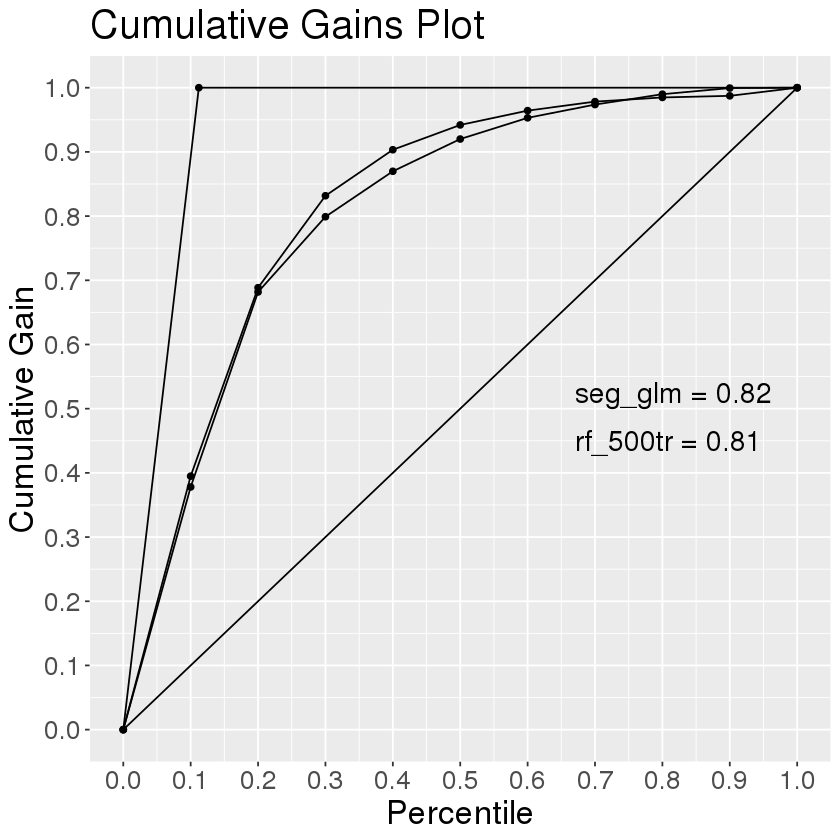

In [65]:

source('functions_eval.R')
plot_multigains(lift_df_list=list(seg_glm = lift_df_seg_glm_expiry_exptest, 
                                  rf_500tr = lift_df_ranger_03_expiry),
                             auc_list = list(seg_glm = calc_auc(lift_df_seg_glm_expiry_exptest), 
                                             rf_500tr= calc_auc(lift_df_ranger_03_expiry)))

# Side issue: phase1 test data for seg_glm and ranger_03 not equivalent

In [36]:
data.frame(first=first_renewal_model_test_predict$renewal_status, test=test_df_f_sub$renewal_status)

first,test
<fct>,<fct>
Renewed,Renewed
Not Renewd,Renewed
Not Renewd,Not Renewd
Renewed,Not Renewd
Renewed,Renewed
Renewed,Not Renewd
Renewed,Renewed
Renewed,Renewed
Renewed,Renewed
